In [1]:
%matplotlib notebook

In [2]:
import random
import numpy as np
import graph_tool as gt
from graph_tool import Graph, GraphView
from graph_tool.topology import random_spanning_tree, isomorphism
from graph_tool.generation import complete_graph, lattice
from graph_tool.draw import sfdp_layout, graph_draw
from scipy.stats import entropy, pearsonr
from matplotlib import pyplot as plt

from tqdm import tqdm

from cascade_generator import si, observe_cascade
from graph_helpers import (extract_steiner_tree, filter_graph_by_edges, extract_edges,
                           extract_nodes, gen_random_spanning_tree, load_graph_by_name)
from core import det_score_of_steiner_tree

from viz_helpers import lattice_node_pos

In [3]:
random.seed(1234)
np.random.seed(1234)
shape = (10, 10)
graph_name = 'karate'
g = load_graph_by_name(graph_name)


In [4]:
s, c, t = si(g, 0.1)
o = observe_cascade(c, s, 0.2)
print(o)

[24 13 33 23]


In [33]:
sample_count = 5000
steiner_trees = []
for _ in tqdm(range(sample_count)):
    rand_t = gen_random_spanning_tree(g)
    st = extract_steiner_tree(rand_t, o)
    steiner_trees.append(st)
det_scores = [det_score_of_steiner_tree(st, g) for st in tqdm(steiner_trees)]
    

100%|██████████| 5000/5000 [01:36<00:00, 51.62it/s]


In [36]:
tree_sizes = np.array([st.num_edges() for st in steiner_trees])
det_scores = np.array(det_scores)
energy_scores = np.exp(-tree_sizes)

In [37]:
print("pearson correlation after log: {:.5f}".format(pearsonr(np.log(det_scores), np.log(energy_scores))[0]))
print("pearson correlation: {:.5f}".format(pearsonr(det_scores, energy_scores)[0]))

pearson correlation after log: 0.98221
pearson correlation: 0.97517


In [51]:
from numpy import random
m = 500
real_scores = np.exp(-tree_sizes)
sampling_importance = real_scores / np.array(det_scores)
sampling_importance /= sampling_importance.sum()
resampled_ids = random.choice(np.arange(len(steiner_trees)), m, replace=False, p=sampling_importance)
steiner_trees_resampled = [steiner_trees[i] for i in resampled_ids]

In [52]:
tree_sizes_resampled = np.array([st.num_edges() for st in steiner_trees_resampled])

<IPython.core.display.Javascript object>


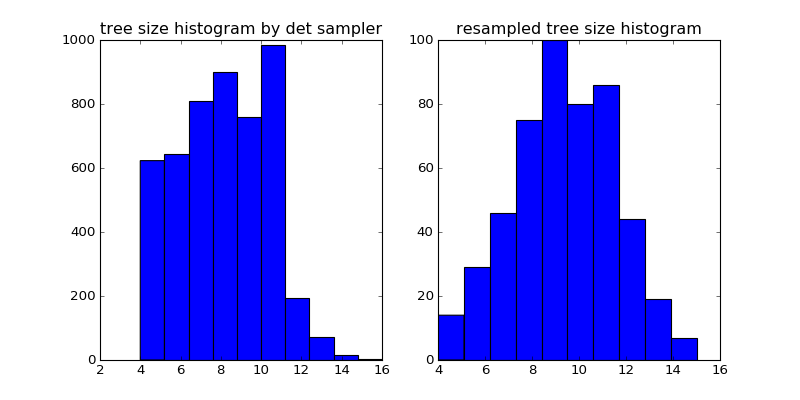

(array([  14.,   29.,   46.,   75.,  100.,   80.,   86.,   44.,   19.,    7.]),
 array([  4. ,   5.1,   6.2,   7.3,   8.4,   9.5,  10.6,  11.7,  12.8,
         13.9,  15. ]),
 <a list of 10 Patch objects>)

In [53]:
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('tree size histogram by det sampler')
ax[0].hist(tree_sizes)
ax[1].set_title('resampled tree size histogram')
ax[1].hist(tree_sizes_resampled)

<IPython.core.display.Javascript object>


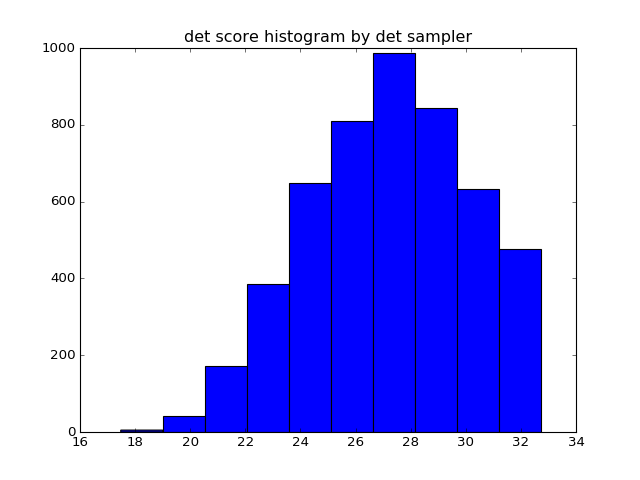

(array([   5.,   41.,  171.,  386.,  648.,  810.,  986.,  845.,  632.,  476.]),
 array([ 17.47881125,  19.00216329,  20.52551533,  22.04886737,
         23.57221941,  25.09557145,  26.61892349,  28.14227553,
         29.66562757,  31.18897961,  32.71233165]),
 <a list of 10 Patch objects>)

In [54]:
plt.subplots(1)
plt.title('det score histogram by det sampler')
plt.hist(np.log(det_scores))

In [12]:
pearsonr(-np.array(tree_sizes), det_scores)

(0.61365533648547976, 0.0)